Takes an AOI and enumerates pairs of SLCs for interferograms.

In [2]:
import geopandas as gpd
import yaml
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import asf_search as asf
from datetime import timedelta
import datetime
from dateparser import parse
import concurrent.futures
import hyp3_sdk
import numpy as np
from data_model import enumParams

# Setup

In [3]:
YAML_FILE = 'enumeration_parameters.yml'
PARAMS = enumParams.from_yaml(YAML_FILE)

In [4]:
PARAMS.__dict__

{'temporal_baseline_days': [0, 90, 180, 365],
 'n_secondaries_per_reference': [4, 2, 2, 2],
 'aoi_name': 'tibet',
 'n_seeds': 2,
 'track_numbers': [136, 33],
 'data_directory': PosixPath('out'),
 'date_of_enum': datetime.date(2024, 3, 1),
 'stack_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/stack'),
 'enum_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum'),
 'yaml_path': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum_params_2024-03-01.yml'),
 'weather_model': None,
 'month_constraint': None,
 'exclusive_month_constraints': False,
 'aoi_geojson_path': PosixPath('AOIs/tibet.geojson'),
 'valid_date_ranges': [[datetime.datetime(2014, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2022, 11, 1, 0, 0, tzinfo=datetime.timezone.utc)]],
 'enum_parent_dir': PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2'),
 'yaml_path_record': PosixPath('enum_configs/tibet_2024-03.yml')}

# Read enumeration data

In [5]:
list(PARAMS.enum_dir.glob('*.geojson'))

[PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum/track33-tibet.geojson'),
 PosixPath('out/tibet__tb_0-90-180-365__neigh_4-2-2-2/enum/track136-tibet.geojson')]

In [6]:
dfs = [gpd.read_file(p) for p in tqdm(list(PARAMS.enum_dir.glob('*.geojson')))]
df_ifg = pd.concat(dfs, axis=0)
df_ifg.head()

100%|██████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]


,reference,secondary,reference_date,secondary_date,frame_id,track_aoi_key,aoi_name,geometry
0,S1A_IW_SLC__1SDV_20221025T231816_20221025T2318...,S1A_IW_SLC__1SDV_20221013T231816_20221013T2318...,2022-10-25,2022-10-13,5033,track33,tibet,"POLYGON Z ((100.25651 40.66807 0.00000, 100.49..."
1,S1A_IW_SLC__1SDV_20221025T231844_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231844_20221013T2319...,2022-10-25,2022-10-13,5034,track33,tibet,"POLYGON Z ((100.01676 39.50849 0.00000, 100.22..."
2,S1A_IW_SLC__1SDV_20221025T231910_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231910_20221013T2319...,2022-10-25,2022-10-13,5035,track33,tibet,"POLYGON Z ((99.77975 38.34848 0.00000, 99.9506..."
3,S1A_IW_SLC__1SDV_20221025T231910_20221025T2319...,S1A_IW_SLC__1SDV_20221013T231910_20221013T2319...,2022-10-25,2022-10-13,5036,track33,tibet,"POLYGON Z ((99.54475 37.18812 0.00000, 99.6462..."
4,S1A_IW_SLC__1SDV_20221025T231935_20221025T2320...,S1A_IW_SLC__1SDV_20221013T231934_20221013T2320...,2022-10-25,2022-10-13,5037,track33,tibet,"POLYGON Z ((99.31155 36.02742 0.00000, 99.3450..."


In [7]:
df_ifg.shape

(19444, 8)

Let's look at each group and its size (i.e. the number of IFGs)

In [8]:
df_count = df_ifg.groupby('track_aoi_key').count().reset_index(drop=False)
df_count['track'] = df_count['track_aoi_key'].map(lambda key: int(key.replace('track', '')))
df_count.sort_values(by='track', inplace=True)
df_count

,track_aoi_key,reference,secondary,reference_date,secondary_date,frame_id,aoi_name,geometry,track
1,track33,11704,11704,11704,11704,11704,11704,11704,33
0,track136,7740,7740,7740,7740,7740,7740,7740,136


In [9]:
for k, row in df_count.iterrows():
    print(row['reference'])

11704
7740


# Filtering Jobs (Optional)

When first submitting jobs, you may just want to submit one track at a time. Easiest to filter on the dataframe with all the IFGs. That's what we will do. Below shows how to filter on a single "track_aoi_id".

In [10]:
df_ifg_submission = df_ifg.copy()

Can uncomment and figure out which track aois to use

In [11]:
# df_ifg_submission = df_ifg[df_ifg.track_aoi_key != 'track106'].reset_index(drop=True)
# df_ifg_submission.head()

In [12]:
from s1_frame_enumerator import get_global_gunw_footprints
import matplotlib.pyplot as plt
import contextily as cx

df_gunw_foot = get_global_gunw_footprints()

In [13]:
frames_enum = df_ifg_submission.frame_id.unique().tolist()
df_gunw_foot_sub = df_gunw_foot[df_gunw_foot.frame_id.isin(frames_enum)].reset_index(drop=True)

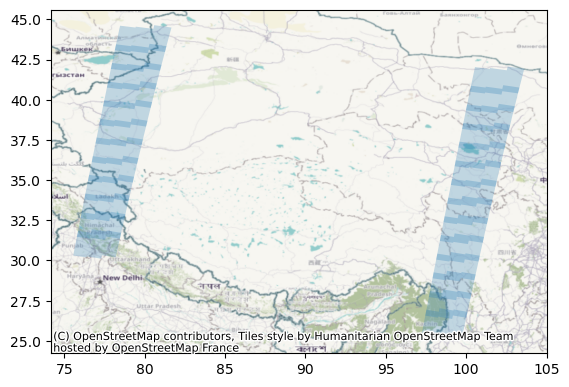

In [14]:
fig, ax = plt.subplots()
df_gunw_foot_sub.plot(ax=ax, alpha=.25)
cx.add_basemap(ax, crs=df_ifg_submission.crs.to_string())

In [15]:
df_ifg_submission.shape

(19444, 8)

# Deduplication of IFGs CMR - Requires CMR Ingest - WIP

**Currently, these cells are non-functional.**

We can use this as the reference for data has been processed. We will use the fixed frames. See this [PR](https://github.com/asfadmin/Discovery-asf_search/issues/198) for more details about how this feature is access through ASF Search.

The raw CMR command for a comparable query is:
```
https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?short_name=SENTINEL-1_INTERFEROGRAMS&temporal=2022-02-24T00:00:00Z,2022-02-25T00:00:00Z&attribute[]=int,FRAME_NUMBER,25502&attribute[]=int,TEMPORAL_BASELINE_DAYS,12
```

Make sure not to use more than 5 threads at a time as that will overload CMR server that handles such requests.

In [16]:
def get_gunw_hits(record):

    frame_id = int(record['frame_id'])
    ref_date = parse(record['reference_date'])
    sec_date = parse(record['secondary_date'])
    
    start = ref_date - timedelta(days=.5)
    end = ref_date + timedelta(days=.5)
    tb_days = (ref_date - sec_date).days
    

    opts = asf.ASFSearchOptions(host='cmr.uat.earthdata.nasa.gov', 
                                platform=asf.SENTINEL1,
                                processingLevel=asf.constants.GUNW_STD,
                                frame=frame_id, 
                                start=start, 
                                end=end, 
                                temporalBaselineDays=[tb_days],
                                maxResults=5
                                )
    
    results = asf.search(opts=opts)
    return len(results)

In [17]:
submission_records = df_ifg_submission.to_dict('records')
#get_gunw_hits(submission_records[0])

In [18]:
n = len(submission_records)
ifg_hits_cmr = 0
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     ifg_hits_cmr = list(tqdm(executor.map(get_gunw_hits, submission_records[:100]), total=n))

In [19]:
# # TODO: set to ifg_hits_cmr
# print('Before dedup: ', df_ifg_submission.shape[0])
# df_ifg_submission['cmr_hits'] = ifg_hits_cmr
# if ifg_hits_cmr:
#     df_ifg_submission = df_ifg_submission[df_ifg_submission['ifg_hits_cmr'] == 0].reset_index(drop=True)
# print('After dedup: ', df_ifg_submission.shape[0])

# Format Job Parameters

We format the dictionary of inputs for the interferograms (IFGs) into the format required by Hyp3 (just reformats into another dictionary).

In [20]:
submission_records[0]

{'reference': 'S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579 S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8',
 'secondary': 'S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA',
 'reference_date': '2022-10-25',
 'secondary_date': '2022-10-13',
 'frame_id': 5033,
 'track_aoi_key': 'track33',
 'aoi_name': 'tibet',
 'geometry': <POLYGON Z ((100.257 40.668 0, 100.497 41.807 0, 103.577 41.807 0, 103.562 4...>}

In [21]:
def generate_job_name(record):
    track_key = record['track_aoi_key']
    aoi_name = record['aoi_name']
    return f'{aoi_name}-{track_key}'

In [22]:
job_names = list(map(generate_job_name, submission_records))
job_names_unique = sorted(list(set(job_names)))
job_names_unique[:5]

['tibet-track136', 'tibet-track33']

## Make sure to select the weather model

In [27]:
WEATHER_MODEL = None

In [30]:
df_us = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
df_conus = df_us[df_us.name != 'Alaska'].reset_index(drop=True)

intersection_conus = df_ifg.iloc[:100].geometry.unary_union.intersects(df_conus.geometry.unary_union)

if intersection_conus and (WEATHER_MODEL is None):
    raise ValueError('Should select HRRRR')

if (WEATHER_MODEL == 'HRRR') and not intersection_conus:
    raise ValueError('HRRR is not valid for GUNW')

In [31]:
job_parameters = [{'granules': record['reference'].split(' '),
                   'secondary_granules': record['secondary'].split(' '),
                   'frame_id': int(record['frame_id']),
                   'weather_model': WEATHER_MODEL,
                  } for record in submission_records]
# Weather model should not be supplied if None
[p.pop('weather_model') for p in job_parameters if p['weather_model'] is None]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579',
   'S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D',
   'S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA'],
  'frame_id': 5033},
 {'granules': ['S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8',
   'S1A_IW_SLC__1SDV_20221025T231910_20221025T231937_045605_0573F5_DD04'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA',
   'S1A_IW_SLC__1SDV_20221013T231910_20221013T231936_045430_056EC3_0D86'],
  'frame_id': 5034}]

In [32]:
job_dicts = [{'name': job_name,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE',
              'job_parameters': parameters
             }
             for parameters, job_name in zip(job_parameters, job_names) ]
job_dicts[:2]

[{'name': 'tibet-track33',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579',
    'S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D',
    'S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA'],
   'frame_id': 5033}},
 {'name': 'tibet-track33',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8',
    'S1A_IW_SLC__1SDV_20221025T231910_20221025T231937_045605_0573F5_DD04'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA',
    'S1A_IW_SLC__1SDV_20221013T231910_20221013T231936_045430_056EC3_0D86'],
   'frame_id': 5034}}]

# Submit Jobs to Hyp3

This is where we take the job dictionaries and submit them to Hyp3. Note, we have different AWS accounts associated to different API endpoints i.e. `hyp3-a19-jpl` and `hyp3-tibet-jpl` are different AWS accounts using the same workflow and are separated for accounting purposes.

In [33]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
#hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu', prompt=True)
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu', prompt=True)

NASA Earthdata Login username:  access_cloud_based_insar
NASA Earthdata Login password:  ········


Can submit one test job.

In [27]:
# Uncomment to submit one test job.
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:1])
# submitted_jobs[0].to_dict()

Grouping jobs by name

In [26]:
##### This is if you want to group batches and submit only one track at a time.

## jobs_by_group = list(map(lambda job_name: [j for j in job_dicts[:]
##                                            if j['name'] == job_name], tqdm(job_names_unique)))

100%|██████████████████████████████████| 2/2 [00:00<00:00, 329.99it/s]


Hyp3 requires us to submit 200 jobs at a time.

In [51]:
batches = [batch for batch in hyp3_sdk.util.chunk(job_dicts, 200)]
batches[0][0], len(batches[0]), len(batches)

({'name': 'tibet-track33',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20221025T231816_20221025T231846_045605_0573F5_C579',
    'S1A_IW_SLC__1SDV_20221025T231844_20221025T231912_045605_0573F5_71C8'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20221013T231816_20221013T231846_045430_056EC3_953D',
    'S1A_IW_SLC__1SDV_20221013T231844_20221013T231912_045430_056EC3_93EA'],
   'frame_id': 5033}},
 200,
 98)

## Submitting the Jobs!

This is where you spend the money!!!

In [52]:
### Submitting all the batches
# hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batch) for batch in tqdm(batches)]

### or to submit certain batches
## hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batches[k]) for k in tqdm(range(2, len(batches)))]

# Check the status of submitted jobs

Check status; note that we use the `start` keyword argument. This massively optimizes search queries (you can use this information in the dynamoDB query).

Also, note that I put the job names as a comment so I can get them later should I want them.

In [63]:
JOB_NAMES_INSPECTION = job_names_unique[:] # ['tibet-track136', 'tibet-track33']
JOB_NAMES_INSPECTION

['tibet-track136', 'tibet-track33']

In [64]:
now = datetime.datetime.now()
submit_time_approx = now - timedelta(hours=96)

In [65]:
for job_name in JOB_NAMES_INSPECTION:
    jobs = hyp3_isce.find_jobs(name=job_name, start=submit_time_approx)
    print('#' * 10)
    print(job_name)
    print(jobs)

##########
tibet-track136
7740 HyP3 Jobs: 6754 succeeded, 986 failed, 0 running, 0 pending.
##########
tibet-track33
11704 HyP3 Jobs: 10270 succeeded, 1434 failed, 0 running, 0 pending.


# Failed jobs

Looked at failed jobs. Again, this will be cleaned up once we ingest into CMR.

In [58]:
now = datetime.datetime.now()
submit_time_approx = now - timedelta(hours=108)

In [45]:
JOB_NAME_INSPECTION = job_names_unique[0]
JOB_NAME_INSPECTION

'tibet-track136'

In [66]:
failed_jobs = []
for job_name in tqdm(job_names_unique):
    data = hyp3_isce.find_jobs(name=job_name, status_code='FAILED', start=submit_time_approx)
    print(job_name, ': n jobs to resubmit ', len(data)) 
    failed_jobs += data
len(failed_jobs)

 50%|█████████████████                 | 1/2 [00:04<00:04,  4.72s/it]

tibet-track136 : n jobs to resubmit  986


100%|██████████████████████████████████| 2/2 [00:10<00:00,  5.41s/it]

tibet-track33 : n jobs to resubmit  1434


2420

In [67]:
dicts_failed = [j.to_dict() for j in failed_jobs ]
dicts_failed[:2]

[{'job_id': '2082d915-2b5b-4b6a-a63d-6eb50d8f0333',
  'job_type': 'INSAR_ISCE',
  'request_time': '2024-02-27T02:27:18+00:00',
  'status_code': 'FAILED',
  'user_id': 'access_cloud_based_insar',
  'name': 'tibet-track136',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 21170,
   'granules': ['S1A_IW_SLC__1SDV_20170402T004918_20170402T004946_015958_01A50A_77EA',
    'S1A_IW_SLC__1SDV_20170402T004944_20170402T005011_015958_01A50A_8467'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20160314T004912_20160314T004940_010358_00F58D_8512',
    'S1A_IW_SLC__1SSV_20160314T004938_20160314T005005_010358_00F58D_1969'],
   'weather_model': 'None'},
  'logs': ['https://hyp3-tibet-jpl-contentbucket-81rn23hp7ppf.s3.us-west-2.amazonaws.com/2082d915-2b5b-4b6a-a63d-6eb50d8f0333/2082d915-2b5b-4b6a-a63d-6eb50d8f0333.log'],
  'expiration_time': '2024-03-31T00:00:00+00:00',
  'processing_times': [1349.048],
  'credit

## To resubmit (Spending money again)

In [68]:
failed_jobs_to_resubmit = [job.to_dict(for_resubmit=True) for job in failed_jobs]
for job in failed_jobs_to_resubmit:
    job['name'] = job['name'] + '_resubmit'
failed_jobs_to_resubmit[0], len(failed_jobs_to_resubmit)

({'job_type': 'INSAR_ISCE',
  'name': 'tibet-track136_resubmit',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 21170,
   'granules': ['S1A_IW_SLC__1SDV_20170402T004918_20170402T004946_015958_01A50A_77EA',
    'S1A_IW_SLC__1SDV_20170402T004944_20170402T005011_015958_01A50A_8467'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20160314T004912_20160314T004940_010358_00F58D_8512',
    'S1A_IW_SLC__1SSV_20160314T004938_20160314T005005_010358_00F58D_1969'],
   'weather_model': 'None'}},
 2420)

In [69]:
batches_resubmit = [batch for batch in hyp3_sdk.util.chunk(failed_jobs_to_resubmit, 200)]
batches_resubmit[0][0], len(batches_resubmit[0]), len(batches_resubmit)

({'job_type': 'INSAR_ISCE',
  'name': 'tibet-track136_resubmit',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 21170,
   'granules': ['S1A_IW_SLC__1SDV_20170402T004918_20170402T004946_015958_01A50A_77EA',
    'S1A_IW_SLC__1SDV_20170402T004944_20170402T005011_015958_01A50A_8467'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20160314T004912_20160314T004940_010358_00F58D_8512',
    'S1A_IW_SLC__1SSV_20160314T004938_20160314T005005_010358_00F58D_1969'],
   'weather_model': 'None'}},
 200,
 13)

In [73]:
### Submitting all the batches
# hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batch) for batch in tqdm(batches_resubmit)]

100%|████████████████████████████████| 13/13 [00:22<00:00,  1.75s/it]


## Tracking resubmits

In [74]:
resubmitted_job_names = list(set(j['name'] for j in failed_jobs_to_resubmit))
resubmitted_job_names

['tibet-track136_resubmit', 'tibet-track33_resubmit']

In [78]:
now = datetime.datetime.now()
resubmit_time_approx = now - timedelta(hours=24)

In [79]:
for job_name in resubmitted_job_names:
    jobs = hyp3_isce.find_jobs(name=job_name, start=resubmit_time_approx)
    print('#' * 10)
    print(job_name)
    print(jobs)

##########
tibet-track136_resubmit
986 HyP3 Jobs: 0 succeeded, 0 failed, 110 running, 876 pending.
##########
tibet-track33_resubmit
1434 HyP3 Jobs: 0 succeeded, 2 failed, 142 running, 1290 pending.
